In [161]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Standard
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from PIL import Image
import scipy

# # Tensorflow and Keras
# from keras.datasets import mnist
# from keras.models import Sequential, Model, Input
# from keras.layers import Dense, Dropout, Activation
# from keras.layers import Conv2D, MaxPooling2D, Flatten
# from tensorflow.keras.optimizers import SGD
# from keras.regularizers import l2
# import tensorflow as tf

# Xception because other model not working
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop

from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#os.chdir('../')
from src import image_preprocess as ip
from src import simple_cnn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Start with histology data
for each 40X, 100X, 200X, 400X, have 644 items for benign and 1300 for malignant

Augment our benign data since we only have ~650 images

In [28]:
# Data is already fairly uniform. No major changes for augmentation
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            fill_mode='constant',
                            cval=0)

In [55]:
print(os.getcwd())
img = Image.open('data/Histology/100X/benign/SOB_B_A-14-22549AB-100-001.png')
x = img_to_array(img)
x.shape

/home/maureen/Documents/Galvanize/Capstone1/Capstone3/Cancer_Prediction


(460, 700, 3)

In [50]:
files = [f for f in os.listdir('data/Histology/100X/benign')]

for f in files:
    img = Image.open(os.path.join('data/Histology/100X/benign',f))
    x = ip.reshape_image(img)
    ip.create_new_images(x)    


In [40]:
root_dir = '/home/maureen/Documents/Galvanize/Capstone1/Capstone3/Cancer_Prediction'

## Make the model

In [93]:
# Taken frm cnn lectures 
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(filters=8, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(460, 700, 3),
                 kernel_regularizer=l2(0.01)))

model.add(MaxPooling2D(pool_size=(2, 2),
                       strides=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(5, 5),
                 strides=(1, 1),
                 activation='relu',
                 kernel_regularizer=l2(0.01)))

model.add(MaxPooling2D(pool_size=(2, 2),
                       strides=(2, 2)))

model.add(Flatten())
model.add(Dense(128,
                activation='relu',
                kernel_regularizer=l2(0.01)))
model.add(Dense(10,
                activation='softmax',
                kernel_regularizer=l2(0.01)))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
model.fit(X_train[..., None], y_train,
          epochs=5,
          verbose=1,
          batch_size=50,
          validation_data=(X_test[..., None], y_test))

In [ ]:
model.layers

In [ ]:
weights1 = model.layers[0].get_weights()[0]
weights1.shape

## Using simplecnn.py, which should be same as above

In [149]:
# Assuming input shape = (width, height, channels) NOT (rows, cols, channels)
model = simple_cnn.create_model(input_size=(500,328,3), n_categories=2)

In [185]:
training_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                      horizontal_flip=True) 

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input
                                       )

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [194]:
train_path = 'data/Histology/100X/train'
val_path = 'data/Histology/100X/validation'
test_path = 'data/Histology/100X/test'

In [196]:
train_generator = training_datagen.flow_from_directory(train_path, 
                                                       target_size=(500, 328), 
                                                       batch_size=16)
validation_generator = validation_datagen.flow_from_directory(val_path, 
                                                              target_size=(500,328), 
                                                              batch_size=16)
test_generator = test_datagen.flow_from_directory(test_path,
                                                 target_size=(500,328),
                                                 batch_size=16)

Found 1666 images belonging to 2 classes.
Found 415 images belonging to 2 classes.
Found 17 images belonging to 1 classes.


In [153]:
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [158]:
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

callback = keras.callbacks.ModelCheckpoint(filepath='models/simplecnn_whc.h5', save_best_only=True)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs")

In [159]:
model.fit_generator(train_generator,
                   steps_per_epoch=1666//16,
                   epochs=3,
                   validation_data=validation_generator,
                   validation_steps=415//16,
                   callbacks=[callback, tensorboard_callback])

Epoch 1/3
104/104 [==============================] - 429s 4s/step - loss: 4.7324 - accuracy: 0.6897 - val_loss: 4.7928 - val_accuracy: 0.6875
Epoch 2/3
104/104 [==============================] - 421s 4s/step - loss: 4.7503 - accuracy: 0.6927 - val_loss: 2.8757 - val_accuracy: 0.6892
Epoch 3/3
104/104 [==============================] - 420s 4s/step - loss: 4.7965 - accuracy: 0.6897 - val_loss: 6.7100 - val_accuracy: 0.6892


## Try Transfer Learning!

In [162]:
# Try new model because previous isn't working
# Using softmax so that we'll get probabilities for predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model

def create_transfer_model(input_size, n_categories, weights = 'imagenet'):
        # note that the "top" is not included in the weights below
        base_model = Xception(weights=weights,
                          include_top=False,
                          input_shape=input_size)
        
        model = base_model.output
        model = GlobalAveragePooling2D()(model)
        predictions = Dense(n_categories, activation='softmax')(model)
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model

In [164]:
model = create_transfer_model((500,328,3),2) 

In [165]:
def print_model_properties(model, indices = 0):
    for i, layer in enumerate(model.layers[indices:]):
        print(i+indices, layer.name,layer.trainable)

In [83]:
print_model_properties(model)

0 input_5 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d_16 True
13 block2_pool True
14 batch_normalization_16 True
15 add_48 True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_17 True
23 block3_pool True
24 batch_normalization_17 True
25 add_49 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_18 True
33 block4_pool True
34 batch_normalization_18 True
35 add_50 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn Tru

Change head

In [166]:
def change_trainable_layers(model, trainable_index):
    for layer in model.layers[:trainable_index]:
        layer.trainable = False
    for layer in model.layers[trainable_index:]:
        layer.trainable = True

In [167]:
_ = change_trainable_layers(model, 132)
print_model_properties(model, 130)

130 block14_sepconv2_bn False
131 block14_sepconv2_act False
132 global_average_pooling2d_6 True
133 dense_4 True


In [175]:
# Compile model. Changed lr from 0.0005 to 0.005
model.compile(optimizer=RMSprop(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [176]:
# Train model can we use fit generator?
model.fit_generator(train_generator,
                   steps_per_epoch=1666//16,
                   epochs=3,
                   validation_data=validation_generator,
                   validation_steps=415//16)
model.save_weights('models/weights.h5')
model.save('models/transfermodel.h5')

Epoch 1/3
  7/104 [=>............................] - ETA: 4:23 - loss: 1.1172 - accuracy: 0.7500

KeyboardInterrupt: 

In [ ]:
## Make predictions!

In [205]:
path = 'data/Histology/100X/test/test/SOB_B_TA-14-13200-100-001.png'

In [206]:
# Single image
img = Image.open(path)
x = img_to_array(img)
images = np.array([x])
images.shape

(1, 328, 500, 3)

In [212]:
model.predict(images)

array([[0.040003, 0.959997]], dtype=float32)

In [216]:
# predict on entire folder
predictions = model.predict(test_generator)
predictions

array([[0.972714, 0.027286],
       [0.032123, 0.967877],
       [0.074094, 0.925906],
       [0.947288, 0.052712],
       [0.375703, 0.624297],
       [0.122902, 0.877098],
       [0.025837, 0.974163],
       [0.96413 , 0.03587 ],
       [0.970251, 0.029749],
       [0.016283, 0.983717],
       [0.034223, 0.965777],
       [0.053022, 0.946978],
       [0.044166, 0.955834],
       [0.038925, 0.961075],
       [0.014544, 0.985456],
       [0.004985, 0.995015],
       [0.049999, 0.950001]], dtype=float32)

In [204]:
test_generator.filenames

['test/SOB_B_TA-14-13200-100-001.png',
 'test/SOB_B_TA-14-13200-100-002.png',
 'test/SOB_B_TA-14-13200-100-003.png',
 'test/SOB_B_TA-14-13200-100-004.png',
 'test/SOB_B_TA-14-13200-100-005.png',
 'test/SOB_M_MC-14-13413-100-030.png',
 'test/SOB_M_MC-14-13413-100-031.png',
 'test/SOB_M_MC-14-13413-100-032.png',
 'test/SOB_M_MC-14-13413-100-033.png',
 'test/SOB_M_MC-14-13413-100-034.png',
 'test/SOB_M_MC-14-13413-100-035.png',
 'test/SOB_M_MC-14-13413-100-036.png',
 'test/SOB_M_MC-14-13413-100-037.png',
 'test/SOB_M_MC-14-13413-100-038.png',
 'test/SOB_M_MC-14-13413-100-039.png',
 'test/SOB_M_MC-14-13413-100-040.png',
 'test/SOB_M_MC-14-13413-100-041.png']

## Try fast AI

In [236]:
from fastai.vision import *

In [238]:
path = Path('data/Histology/40X/train/')

In [239]:
# Go through folder, resize anything larger than 500 pix
for folder in ['benign', 'malignant']:
    print(folder)
    verify_images(path/folder, delete=True, max_size=500)

benign


malignant


In [240]:
# Set up validation percent
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                 ds_tfms=get_transforms(), size=224, 
                                  num_workers=4).normalize(imagenet_stats)

In [243]:
data.classes
import torch
print(torch.cuda.is_available())


False


In [242]:
data.show_batch(rows=4)

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [125]:
data.c
len(data.train_ds), len(data.valid_ds)

(1665, 416)

In [126]:
## Start training
from fastai.metrics import error_rate

In [244]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [128]:
defaults.device = torch.device('cuda')
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.916973,0.262515,0.093750,03:26
1,0.616882,0.257399,0.081731,03:27
2,0.461228,0.203368,0.076923,03:18
3,0.373855,0.202627,0.079327,03:40


In [129]:
learn.save('histology_100x_v1')
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


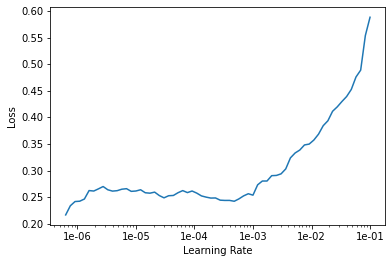

In [130]:
learn.recorder.plot()

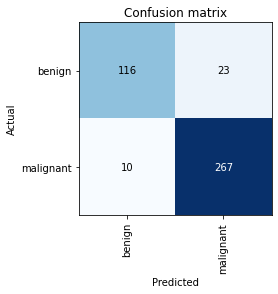

In [160]:
metric = ClassificationInterpretation.from_learner(learn)
metric.plot_confusion_matrix()

In [233]:
path = 'data/Histology/100X/test/test/SOB_M_MC-14-13413-100-035.png'
image = open_image(path)
data = ItemBase(path)
learn.predict(image)

(Category tensor(1), tensor(1), tensor([0.0066, 0.9934]))

In [235]:
np.random.randint(0,100)

31

In [33]:
## For Mammograms

In [ ]:
# Data is already fairly uniform. No major changes for augmentation
datagen = ImageDataGenerator(rotation_range=5,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            fill_mode='constant',
                            cval=0)